In [1]:
import numpy as np
import tensorflow as tf
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time
from IPython.display import clear_output
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
filename = 'data/dataset_IM_1B.pkl'

with open(filename, 'rb') as f:
    data_tuples = pickle.load(f)
f.close()

In [3]:
print('Number of Data Points:', len(data_tuples))
class_labels = []
for i in range(len(data_tuples)):
    class_labels.append(data_tuples[i][1])

print('Class Labels:', len(set(class_labels)))
print('Feature Count:', len(data_tuples[0][0]) ** 2)

Number of Data Points: 6000
Class Labels: 6
Feature Count: 784


In [4]:
# intrinsic dimension performed elsewhere

data = pd.DataFrame([i[0].flatten() for i in data_tuples])
labels = np.array([i[1] for i in data_tuples])
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [5]:
# currently just operates with batch size of 128

def main(ID, flags_nb_epochs, flags_eps, flags_eps_iter):
    
    # 1. load and split data
    data = pd.DataFrame([i[0].flatten() for i in data_tuples])
    labels = np.array([i[1] for i in data_tuples])
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

    # 2. define model architecture with intrinsic dimension and loss/optimization
    model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(28*28)),
                tf.keras.layers.Dense(ID, activation='relu'),
                tf.keras.layers.Dense(6)
            ])
    loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.001)
    
    # 3. define metrics to track the different accuracies.
    train_loss = tf.metrics.Mean(name="train_loss")
    test_acc_clean = tf.metrics.SparseCategoricalAccuracy()
    test_acc_fgsm = tf.metrics.SparseCategoricalAccuracy()
    test_acc_pgd = tf.metrics.SparseCategoricalAccuracy()
    
    # 3a. define training function
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            predictions = model(x)
            loss = loss_object(y, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)
    
    # 4. train model with normal training
    for epoch in range(flags_nb_epochs):
        # keras like display of progress
        progress_bar_train = tf.keras.utils.Progbar(len(x_train))
        for i in range(round(len(x_train)/128)):
            a,b = (128*i, min(128*(i+1), len(x_train)-1))
            x_batch = x_train.iloc[a:b]
            x_batch = tf.constant(x_batch.astype('float32'))
            y_batch = y_train[a:b]
            train_step(x_batch, y_batch)
            progress_bar_train.add(x_batch.shape[0], values=[("loss", train_loss.result())])
                
    # 5. evaluate on clean and adversarial data
    progress_bar_test = tf.keras.utils.Progbar(10000)
    for i in range(round(len(x_test)/128)):
        a,b = (128*i, min(128*(i+1), len(x_test)-1))
        x_batch = x_train.iloc[a:b]
        x_batch = tf.constant(x_batch.astype('float32'))
        y_batch = y_train[a:b]

        y_pred = model(x_batch)
        test_acc_clean(y_batch, y_pred)

        x_fgm = fast_gradient_method(model, x_batch, flags_eps, np.inf)
        y_pred_fgm = model(x_fgm)
        test_acc_fgsm(y_batch, y_pred_fgm)

        x_pgd = projected_gradient_descent(model, x_batch, flags_eps, flags_eps_iter, 40, np.inf)
        y_pred_pgd = model(x_pgd)
        test_acc_pgd(y_batch, y_pred_pgd)

        progress_bar_test.add(x_batch.shape[0])
        
    # 6. print accuracies on the data
    print(
        "\ntest acc on clean examples (%): {:.3f}".format(test_acc_clean.result() * 100)
    )
    print(
        "test acc on FGM adversarial examples (%): {:.3f}".format(
            test_acc_fgsm.result() * 100
        )
    )
    print(
        "test acc on PGD adversarial examples (%): {:.3f}".format(
            test_acc_pgd.result() * 100
        )
    )
    
    return x_batch, x_fgm, x_pgd, y_batch, y_pred, y_pred_fgm, y_pred_pgd

In [6]:
# ID, epochs, epsilon, iterations on epsilon
for id in [20, 300]:
    x_batch, x_fgm, x_pgd, y_batch, y_pred, y_pred_fgm, y_pred_pgd = main(id, 10, 0.01, 0.01)

 1152/10000 [==>...........................] - ETA: 3s loss
test acc on clean examples (%): 100.000
test acc on FGM adversarial examples (%): 97.917
test acc on PGD adversarial examples (%): 97.830
 1152/10000 [==>...........................] - ETA: 4s
test acc on clean examples (%): 100.000
test acc on FGM adversarial examples (%): 99.653
test acc on PGD adversarial examples (%): 99.653


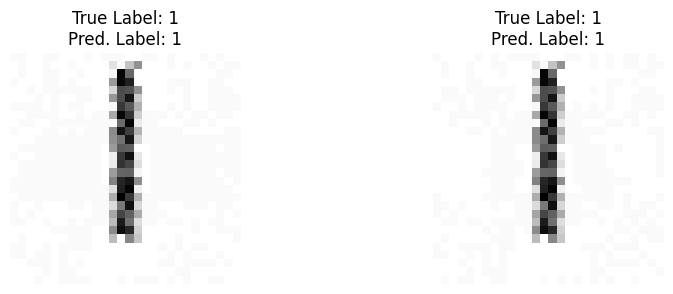

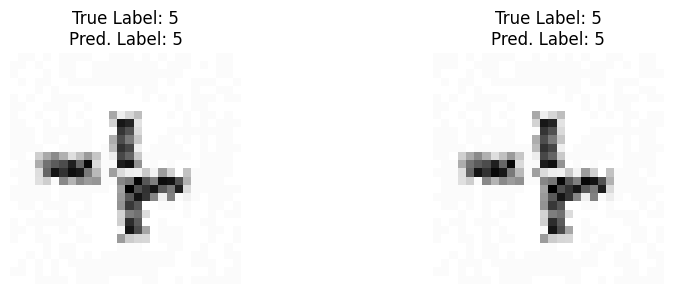

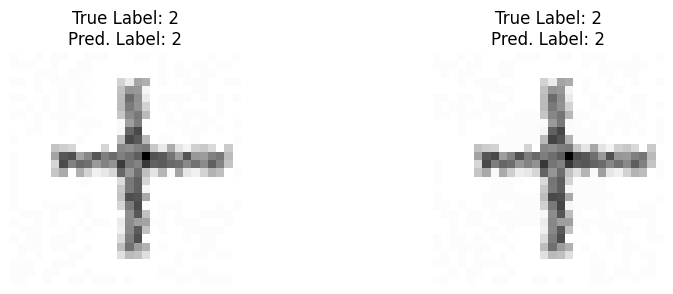

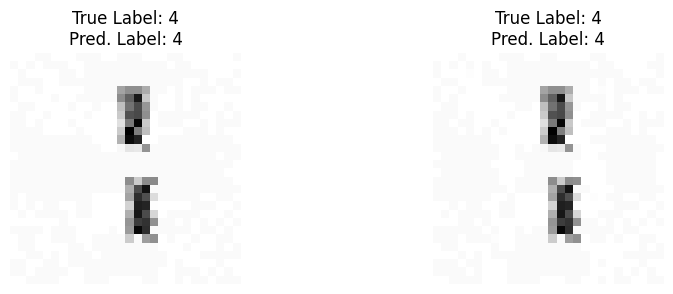

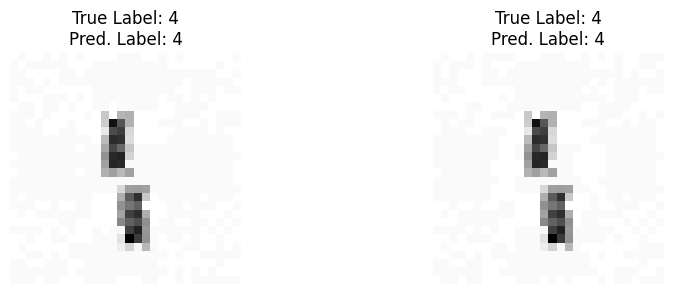

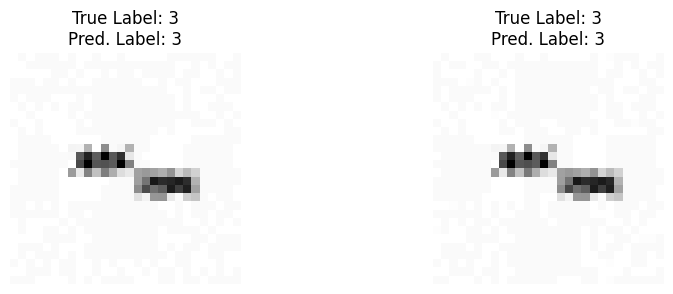

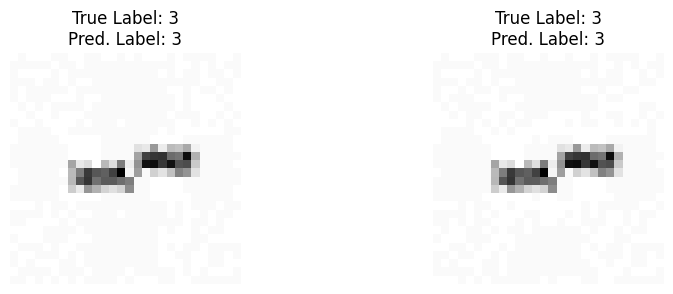

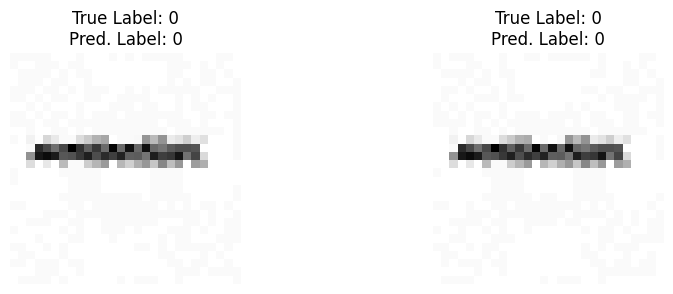

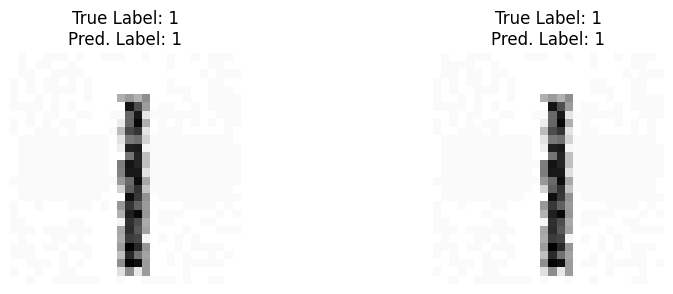

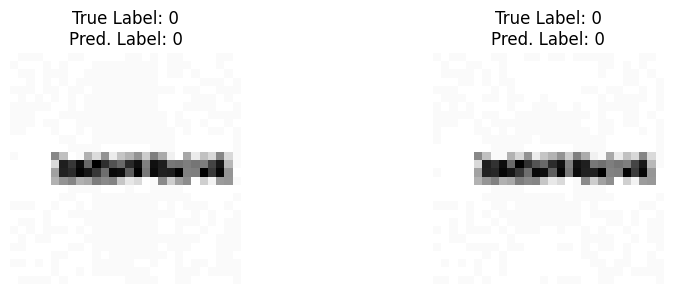

In [7]:
for index in range(0,10):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    for ax, image, label, pred in zip(axes, 
                                [x_fgm, x_pgd], 
                                np.full((10), y_batch[index]),
                                [np.argmax(y_pred_fgm[index]), np.argmax(y_pred_pgd[index])]
                               ):
        image = image[index].numpy()
        ax.set_axis_off()
        ax.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title("True Label: {}\nPred. Label: {}".format(label, pred))